# Image Captioning Bot:-
#### It genrates caption for the given image using Transfer learning and NLP

### Steps 
- Data collection
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import collections
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [139]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [140]:
captions = readTextFile("captions.txt").split('\n')[1:-1]

In [141]:
captions

['1000268201_693b08cb0e.jpg~A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg~A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg~A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg~A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg~A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg~A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg~A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg~A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg~Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg~Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg~A little girl covered in paint sits in front of a painted rainbow with her hands in a 

In [142]:
len(captions)

40455

In [143]:
img_name  = list(set([i.split('~')[0] for i in captions]))
# captions.split('~')
# print(img_name)
# print(caption)

In [144]:
with open("train.txt","w") as f:
    f.write(str(img_name[:int(len(img_name)*0.8)]))
with open("test.txt","w") as f:
    f.write(str(img_name[int(len(img_name)*0.8):]))

### Grouping Images with all it's captions

In [145]:
descriptions = {}

for x in captions:
    img_name,caption  = x.split('~')
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(caption)

In [146]:
descriptions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

### Displaying Image with it's Descreption

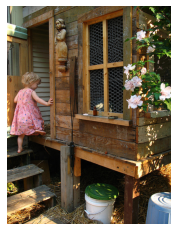

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [147]:
IMG_PATH = "./Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
descriptions["1000268201_693b08cb0e.jpg"]

### Data Cleaning of Captions:-
#### removing special characters from the captions liks #,1-9 etc.

In [148]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [149]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [150]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [151]:
descriptions["1000268201_693b08cb0e.jpg"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [152]:
# Write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

## Creating Vocabulary

In [153]:
## Very big vocabulary 

#vocab = set()
#for key in descriptions.keys():
#    [vocab.update(sentence.split()) for sentence in descriptions[key]]
#    
#print("Size : %d"% len(vocab))

In [154]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Number of Total Words : %d"%len(total_words))

Number of Total Words : 373803


In [155]:
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [156]:
counter

Counter({'child': 1545,
         'in': 18986,
         'pink': 739,
         'dress': 348,
         'is': 9345,
         'climbing': 507,
         'up': 1302,
         'set': 109,
         'of': 6723,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 53,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18419,
         'to': 3176,
         'her': 1178,
         'cabin': 4,
         'black': 3848,
         'dog': 8138,
         'and': 8862,
         'spotted': 38,
         'are': 3504,
         'fighting': 133,
         'tri': 14,
         'colored': 221,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10745,
         'road': 398,
         'white': 3959,
         'brown': 2578,
         'spots': 29,
         'staring': 57,
         'at': 2915,
         'street': 

In [157]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [158]:
sorted_freq_cnt

[('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723),
 ('two', 5642),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2915),
 ('people', 2883),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1787),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1387),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1236),
 ('green', 1234),
 ('one', 1222),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

### Prepare Train/Test Data

In [159]:
train_file_data = readTextFile("train.txt")
test_file_data = readTextFile("test.txt")

In [160]:
train = train_file_data.split(",")
test = test_file_data.split(",")

In [161]:
train = [x.split('\'')[1] for x in train]
test = [x.split('\'')[1] for x in test]

In [162]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [163]:
train_descriptions["1000268201_693b08cb0e.jpg"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [164]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [165]:
model_new = Model(model.input,model.layers[-2].output)

In [166]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [167]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [168]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [169]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535922, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [170]:
len(train)

6472

In [171]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [172]:
!mkdir saved

In [173]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [174]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Test Encoding in Progress Time step 1000 
Test Encoding in Progress Time step 1100 
Test Encoding in Progress Time step 1200 
Test Encoding in Progress Time step 1300 
Test Encoding in Progress Time step 1400 
Test Encoding in Progress Time step 1500 
Test Encoding in Progress Time step 1600 
Total Time Taken(test) : 323.8049123287201


In [175]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [176]:
# Vocab
len(total_words)

1845

In [177]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [178]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [179]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [180]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


### Data Loader (Generator)

In [203]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [182]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [183]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [184]:
f.close()

In [185]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [186]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [187]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [188]:
#embedding_matrix[1847]

#### Model Architecture

In [189]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [190]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [191]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [192]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_5[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [193]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [194]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [209]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//3

In [210]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [211]:
train()

<ipython-input-210-9bcaf1db53bc>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


2157/2157 [==============================] - 414s 191ms/step - loss: 4.2723 4:06 -  - ETA: 3:59 - loss: 4 - ETA: 3 - ETA: 3:55 - loss: 4. - ETA: 3:54 - loss: 4 - ETA: 3:53 - l - ETA: 3:51 - loss: 4.637 - ETA: 3:51 - loss:  - ETA: 3:50 - loss: 4.636 - ETA: 3:49 - loss: 4.63 - ETA: 3:49 - ETA - ETA: 3:42 - loss:  - ETA: 3:41 - loss:  - ETA: 3:14 - loss: 4.5 - ETA: 3:14 - loss: - ETA - ETA: 2:43 - los - ETA: - ETA: 2:33 - loss: 4.47 - ETA: 2:27 - loss: - ETA: 2:26 - loss: - ETA: 2:25 - loss: 4. - ETA: 2:24 - loss: 4.4 - ETA: 2:23 - loss: 4.45 - ETA: 2:23 - loss:  - ETA: 2:22 - loss: - ETA: 2:15 - loss: - ETA: 2:14 - loss: 4.437 - ETA - ETA: 2:10 - loss: - ET - ETA: 2:04 - los - ETA: 2 - ETA: 1:54 - loss: 4.407 - ET - ETA: 1: - ETA: 1:46 - los -  - ETA: - ET - ETA: 1:27 - loss: 4.3 - ETA: 1:26 - l - ETA: 1:24 - loss: 4. - ETA: 1:23 - loss: 4.370 - ETA: 1:23 - loss: - ETA: 1:22 - lo - ETA: 1:20 - loss: 4. - ETA: 1:19 - loss: 4 - ETA: 1:18 - loss: 4 - ETA: 1:1 - ETA: 1:14 - los - ETA: 1 - - 

C:\Users\soura\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2157/2157 [==============================] - 421s 195ms/step - loss: 2.6068


In [212]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [213]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

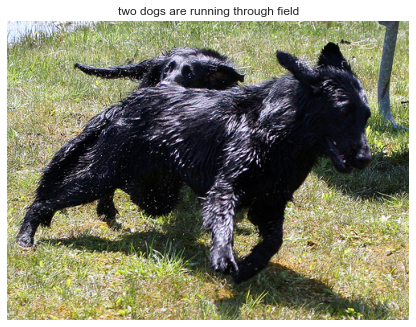

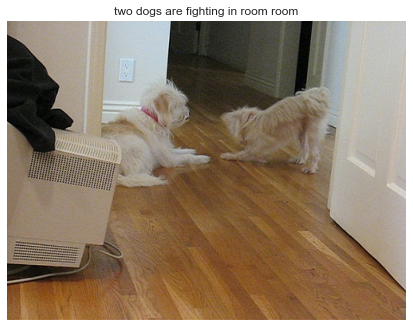

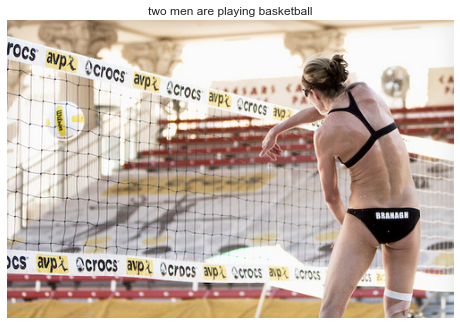

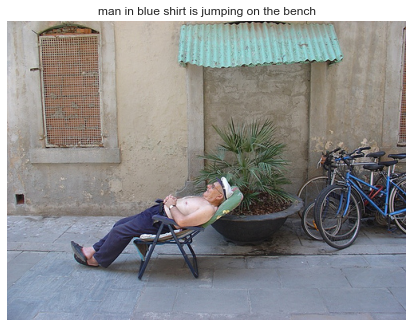

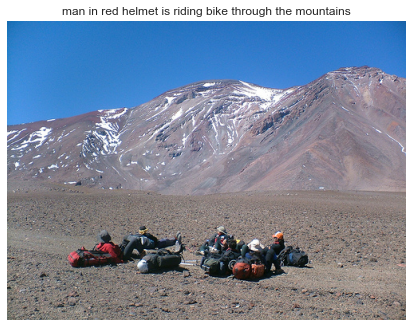

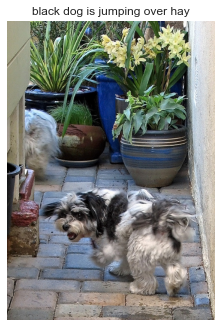

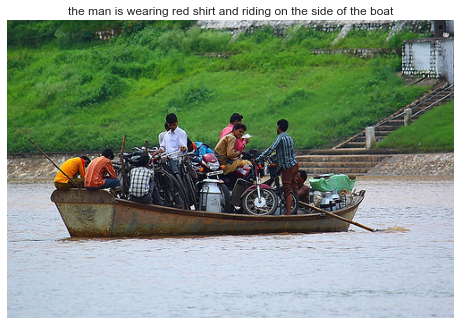

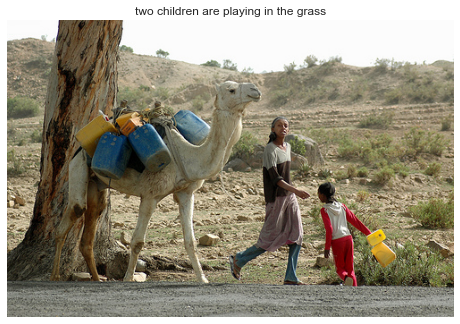

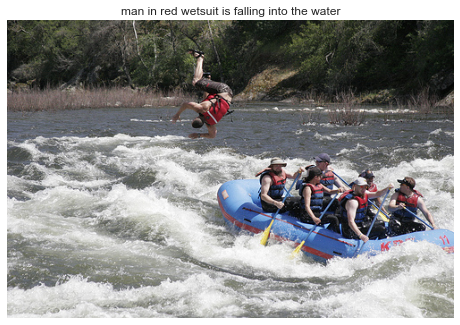

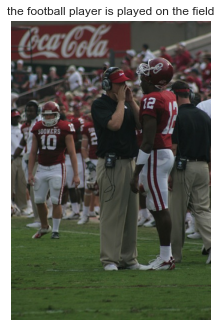

In [214]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./Images/"+img_name)
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [218]:
#encoding_test["3385593926_d3e9c21170"].shape